<a href="https://colab.research.google.com/github/GerardAlba/UdAAnaliticaFinancera/blob/main/UdAInsuranceClaimsFraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud-Detection Kaggle

In [1]:
!pip install pandas==1.5.3

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [5]:
data = pd.read_csv('insuranceFraud.csv')

In [6]:
data.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,10/17/2014,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,6/27/2006,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,9/6/2000,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,5/25/1990,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,6/6/2014,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [7]:
data.shape

(1000, 39)

#### Correct Data Format

In [8]:
# Replace "?" values with NAN for imputer
data = data.replace('?', np.nan)

#### Drop Uselesss Columns

In [9]:
data.columns

Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported'],
      dtype='object')

In [10]:
dropable_columns = ['policy_number','policy_bind_date','policy_state','insured_zip','incident_location','incident_date','incident_state','incident_city','auto_make','auto_model','auto_year']

In [11]:
data.drop(dropable_columns,1,inplace=True)

<ipython-input-11-0acbdb898167>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop(dropable_columns,1,inplace=True)


In [12]:
data.shape

(1000, 28)

#### Check Null values and Replace by Mode

In [13]:
data.isnull().sum()

,0
months_as_customer,0
age,0
policy_csl,0
policy_deductable,0
policy_annual_premium,0
umbrella_limit,0
insured_sex,0
insured_education_level,0
insured_occupation,0
insured_hobbies,0


In [14]:
data_mode = dict(data.mode().iloc[0])

In [15]:
data = data.fillna(data_mode)

#### Data Description

In [16]:
data.describe()

,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,1136.000000,1256.406150,1.101000e+06,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000
std,115.113174,9.140287,611.864673,244.167395,2.297407e+06,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893
min,0.000000,19.000000,500.000000,433.330000,-1.000000e+06,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000
25%,115.750000,32.000000,500.000000,1089.607500,0.000000e+00,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000
50%,199.500000,38.000000,1000.000000,1257.200000,0.000000e+00,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000
75%,276.250000,44.000000,2000.000000,1415.695000,0.000000e+00,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000
max,479.000000,64.000000,2000.000000,2047.590000,1.000000e+07,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000


In [17]:
data.corr()

<ipython-input-17-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim
months_as_customer,1.000000,0.922098,0.026807,0.005018,0.015498,0.006399,0.020209,0.070639,0.014736,-0.010162,0.058383,0.062108,0.065329,0.034940,0.061013
age,0.922098,1.000000,0.029188,0.014404,0.018126,-0.007075,0.007368,0.087161,0.022102,-0.015679,0.052359,0.069863,0.075522,0.060898,0.062588
policy_deductable,0.026807,0.029188,1.000000,-0.003245,0.010870,0.035212,-0.023544,0.060935,0.051214,-0.022765,0.066639,0.022839,0.039107,0.064792,0.005269
policy_annual_premium,0.005018,0.014404,-0.003245,1.000000,-0.006247,-0.013738,0.023547,-0.001578,-0.045991,0.026780,0.002332,0.009094,-0.017633,-0.011654,0.020246
umbrella_limit,0.015498,0.018126,0.010870,-0.006247,1.000000,-0.047268,-0.024056,-0.023257,-0.021270,0.022743,-0.006738,-0.040344,-0.045412,-0.023790,-0.038584
capital-gains,0.006399,-0.007075,0.035212,-0.013738,-0.047268,1.000000,-0.046904,-0.016406,0.061643,0.055829,-0.017651,0.015980,0.025934,-0.000779,0.015836
capital-loss,0.020209,0.007368,-0.023544,0.023547,-0.024056,-0.046904,1.000000,-0.025054,-0.014895,-0.024418,-0.041330,-0.036060,-0.046060,-0.022863,-0.032665
incident_hour_of_the_day,0.070639,0.087161,0.060935,-0.001578,-0.023257,-0.016406,-0.025054,1.000000,0.120794,-0.034563,0.006527,0.217702,0.165768,0.179536,0.215626
number_of_vehicles_involved,0.014736,0.022102,0.051214,-0.045991,-0.021270,0.061643,-0.014895,0.120794,1.000000,0.014030,-0.014669,0.274278,0.224650,0.219084,0.269393
bodily_injuries,-0.010162,-0.015679,-0.022765,0.026780,0.022743,0.055829,-0.024418,-0.034563,0.014030,1.000000,-0.005606,0.047093,0.047319,0.039749,0.043449


#### Graph Plotting

<ipython-input-18-dee1b0fcd22f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(data.corr(),linewidths=.5,square=True,center=0,annot=True)


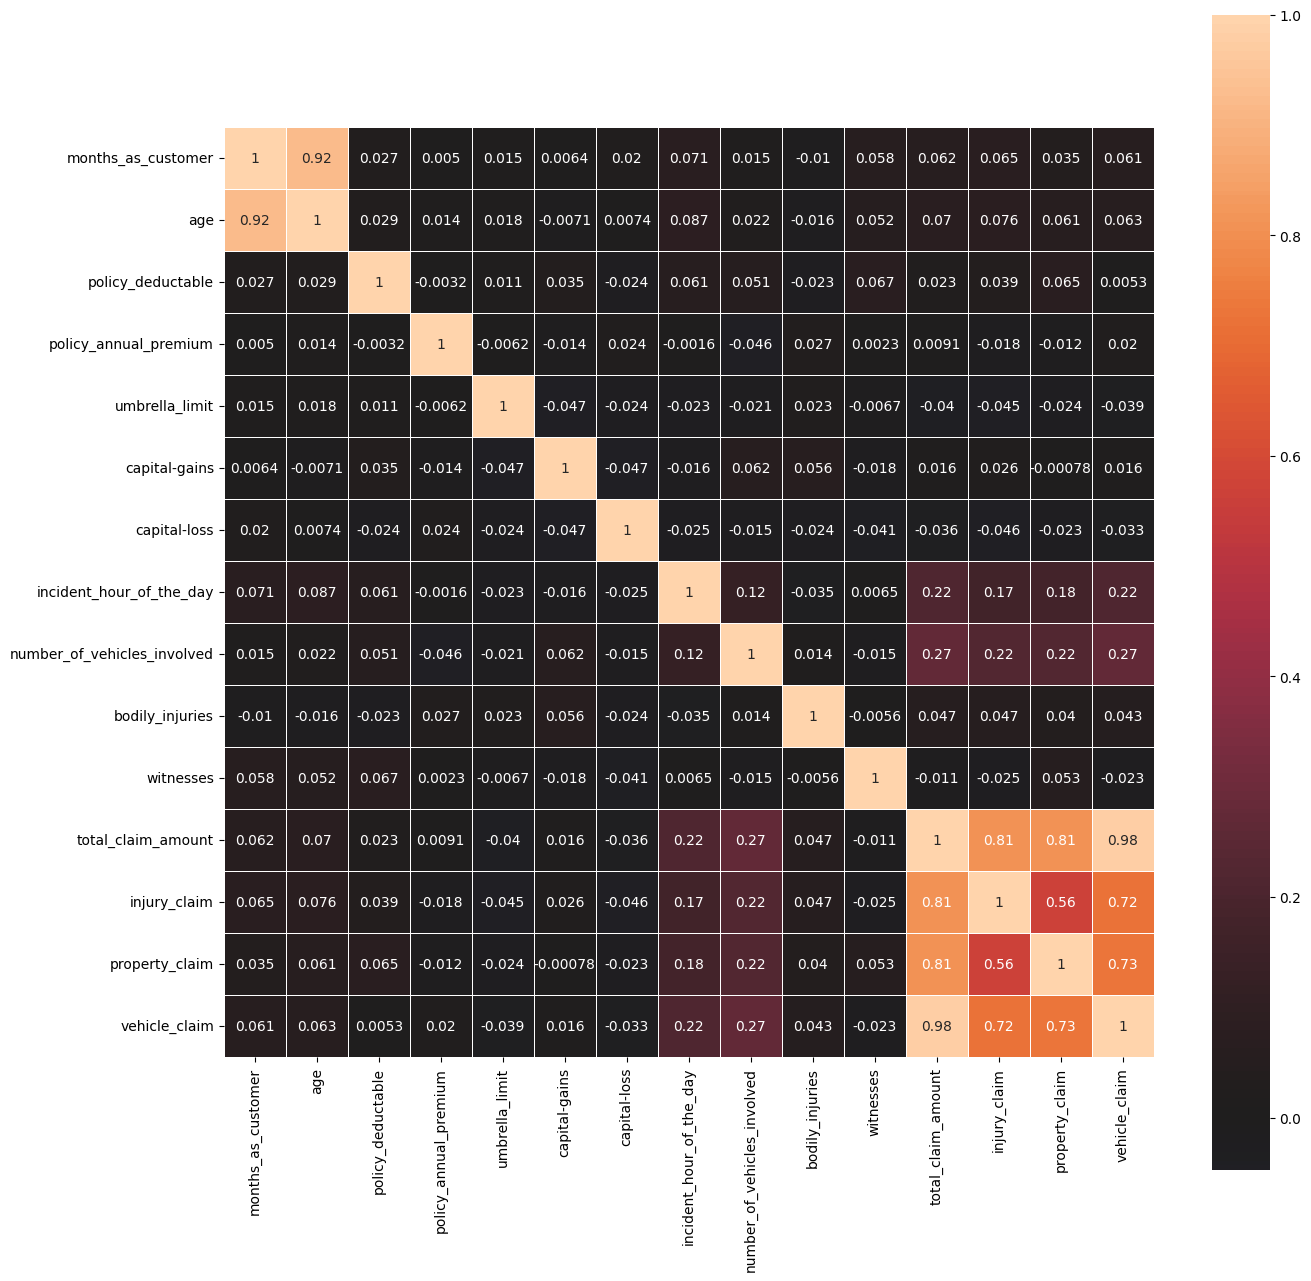

In [18]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(data.corr(),linewidths=.5,square=True,center=0,annot=True)

In [19]:
data.columns

Index(['months_as_customer', 'age', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'fraud_reported'],
      dtype='object')

<Axes: xlabel='insured_hobbies', ylabel='count'>

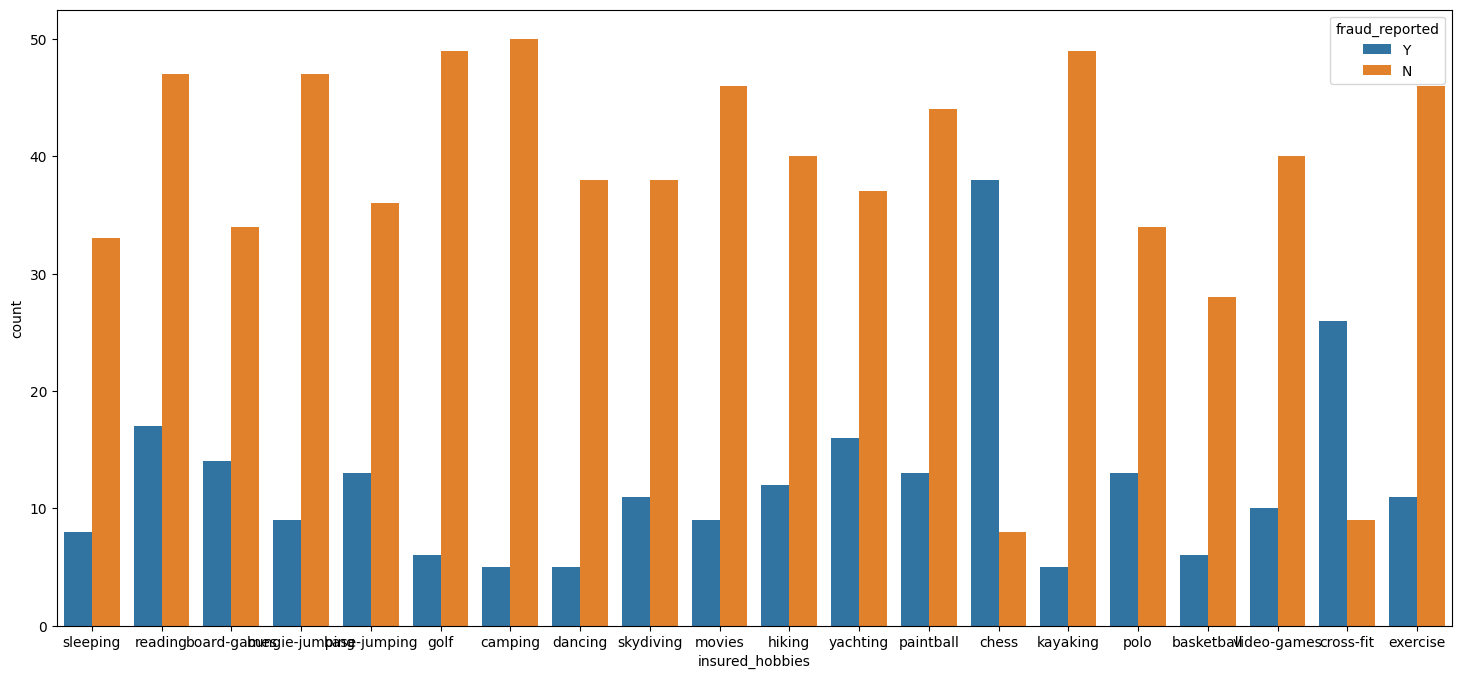

In [20]:
f, ax = plt.subplots(figsize=(18, 8))
sns.countplot(x='insured_hobbies',hue='fraud_reported',data=data)

###### Check Data is Balanced Or Not
> Data has Imbalanced Classses

<Axes: xlabel='fraud_reported', ylabel='count'>

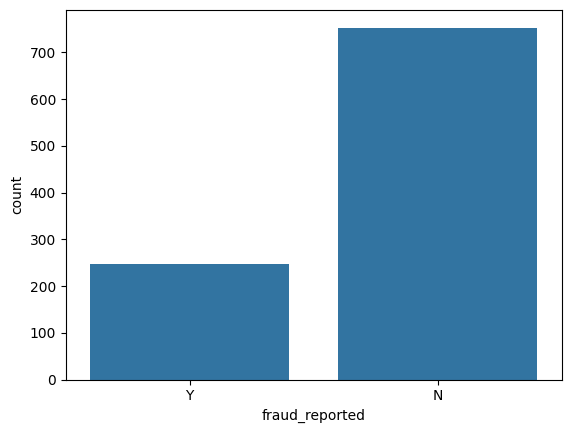

In [21]:
sns.countplot(x='fraud_reported',data=data)

#### Label Encoder and OneHotEncoder

In [22]:
cat_df = data.select_dtypes(include=['object']).copy()

In [23]:
num_df = data.select_dtypes(include=["int64"]).copy()

In [24]:
cat_df.head()

,policy_csl,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,incident_type,collision_type,incident_severity,authorities_contacted,property_damage,police_report_available,fraud_reported
0,250/500,MALE,MD,craft-repair,sleeping,husband,Single Vehicle Collision,Side Collision,Major Damage,Police,YES,YES,Y
1,250/500,MALE,MD,machine-op-inspct,reading,other-relative,Vehicle Theft,Rear Collision,Minor Damage,Police,NO,NO,Y
2,100/300,FEMALE,PhD,sales,board-games,own-child,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NO,NO,N
3,250/500,FEMALE,PhD,armed-forces,board-games,unmarried,Single Vehicle Collision,Front Collision,Major Damage,Police,NO,NO,Y
4,500/1000,MALE,Associate,sales,board-games,unmarried,Vehicle Theft,Rear Collision,Minor Damage,None,NO,NO,N


In [25]:
cat_df.columns

Index(['policy_csl', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'property_damage', 'police_report_available',
       'fraud_reported'],
      dtype='object')

In [26]:
for column in cat_df.columns:
    le = LabelEncoder()
    cat_df[column] = le.fit_transform(cat_df[column])

In [27]:
cat_df.head()

,policy_csl,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,incident_type,collision_type,incident_severity,authorities_contacted,property_damage,police_report_available,fraud_reported
0,1,1,4,2,17,0,2,2,0,4,1,1,1
1,1,1,4,6,15,2,3,1,1,4,0,0,1
2,0,0,6,11,2,3,0,1,1,4,0,0,0
3,1,0,6,1,2,4,2,0,0,4,0,0,1
4,2,1,0,11,2,4,3,1,1,2,0,0,0


In [28]:
num_df.head()

,months_as_customer,age,policy_deductable,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim
0,328,48,1000,0,53300,0,5,1,1,2,71610,6510,13020,52080
1,228,42,2000,5000000,0,0,8,1,0,0,5070,780,780,3510
2,134,29,2000,5000000,35100,0,7,3,2,3,34650,7700,3850,23100
3,256,41,2000,6000000,48900,-62400,5,1,1,2,63400,6340,6340,50720
4,228,44,1000,6000000,66000,-46000,20,1,0,1,6500,1300,650,4550


In [29]:
final_df = pd.concat([num_df,cat_df], axis=1)

In [30]:
final_df.head()

,months_as_customer,age,policy_deductable,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,...,insured_occupation,insured_hobbies,insured_relationship,incident_type,collision_type,incident_severity,authorities_contacted,property_damage,police_report_available,fraud_reported
0,328,48,1000,0,53300,0,5,1,1,2,...,2,17,0,2,2,0,4,1,1,1
1,228,42,2000,5000000,0,0,8,1,0,0,...,6,15,2,3,1,1,4,0,0,1
2,134,29,2000,5000000,35100,0,7,3,2,3,...,11,2,3,0,1,1,4,0,0,0
3,256,41,2000,6000000,48900,-62400,5,1,1,2,...,1,2,4,2,0,0,4,0,0,1
4,228,44,1000,6000000,66000,-46000,20,1,0,1,...,11,2,4,3,1,1,2,0,0,0


In [31]:
target_value = 'fraud_reported'
X = final_df.drop([target_value],1)
y = final_df[target_value]

<ipython-input-31-ec5657783c4d>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = final_df.drop([target_value],1)


#### Split data into train and test

In [32]:
train_X, test_X , train_y, test_y = train_test_split(X, y, test_size =0.3, random_state = 2020)

## Train The Model

### RandomForestClassifier

In [33]:
clf = RandomForestClassifier(n_estimators=100)

In [34]:
pred_y = clf.fit(train_X, train_y).predict(test_X)

In [35]:
accuracy_score(test_y, pred_y)

0.76

In [ ]:
confusion_matrix(test_y, pred_y)

array([[199,  29],
       [ 49,  23]])

In [ ]:
roc_auc_score(test_y, pred_y)

0.596125730994152

#####  Roc Curve

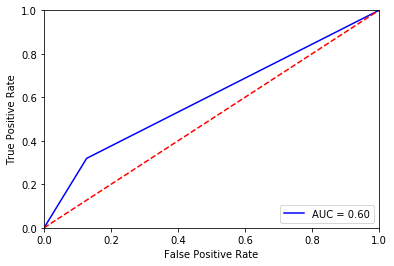

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(test_y, pred_y)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Support Vector Classifier

In [ ]:
clf2 = SVC()

In [ ]:
pred2_y = clf2.fit(train_X, train_y).predict(test_X)

In [ ]:
accuracy_score(test_y, pred2_y)

0.76

In [ ]:
confusion_matrix(test_y, pred2_y)

array([[228,   0],
       [ 72,   0]])

In [ ]:
roc_auc_score(test_y, pred2_y)

0.5

##### GridSearchCv For Better Accuracy

In [ ]:
param_grid = {"kernel": ['rbf','sigmoid'],
             "C":[0.1,0.5,1.0],
             "random_state":[0,10,20,30]}

In [ ]:
grid = GridSearchCV(estimator=clf2, param_grid=param_grid, cv=5,  verbose=3)

In [ ]:
grid.fit(train_X, train_y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] C=0.1, kernel=rbf, random_state=0 ...............................
[CV] ... C=0.1, kernel=rbf, random_state=0, score=0.750, total=   0.0s
[CV] C=0.1, kernel=rbf, random_state=0 ...............................
[CV] ... C=0.1, kernel=rbf, random_state=0, score=0.750, total=   0.0s
[CV] C=0.1, kernel=rbf, random_state=0 ...............................
[CV] ... C=0.1, kernel=rbf, random_state=0, score=0.750, total=   0.0s
[CV] C=0.1, kernel=rbf, random_state=0 ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ... C=0.1, kernel=rbf, random_state=0, score=0.750, total=   0.0s
[CV] C=0.1, kernel=rbf, random_state=0 ...............................
[CV] ... C=0.1, kernel=rbf, random_state=0, score=0.750, total=   0.0s
[CV] C=0.1, kernel=rbf, random_state=10 ..............................
[CV] .. C=0.1, kernel=rbf, random_state=10, score=0.750, total=   0.0s
[CV] C=0.1, kernel=rbf, random_state=10 ..............................
[CV] .. C=0.1, kernel=rbf, random_state=10, score=0.750, total=   0.0s
[CV] C=0.1, kernel=rbf, random_state=10 ..............................
[CV] .. C=0.1, kernel=rbf, random_state=10, score=0.750, total=   0.0s
[CV] C=0.1, kernel=rbf, random_state=10 ..............................
[CV] .. C=0.1, kernel=rbf, random_state=10, score=0.750, total=   0.0s
[CV] C=0.1, kernel=rbf, random_state=10 ..............................
[CV] .. C=0.1, kernel=rbf, random_state=10, score=0.750, total=   0.0s
[CV] C=0.1, kernel=rbf, random_state=20 ..............................
[CV] .

[CV]  C=0.5, kernel=sigmoid, random_state=10, score=0.743, total=   0.0s
[CV] C=0.5, kernel=sigmoid, random_state=10 ..........................
[CV]  C=0.5, kernel=sigmoid, random_state=10, score=0.750, total=   0.0s
[CV] C=0.5, kernel=sigmoid, random_state=10 ..........................
[CV]  C=0.5, kernel=sigmoid, random_state=10, score=0.750, total=   0.0s
[CV] C=0.5, kernel=sigmoid, random_state=10 ..........................
[CV]  C=0.5, kernel=sigmoid, random_state=10, score=0.750, total=   0.0s
[CV] C=0.5, kernel=sigmoid, random_state=10 ..........................
[CV]  C=0.5, kernel=sigmoid, random_state=10, score=0.750, total=   0.0s
[CV] C=0.5, kernel=sigmoid, random_state=20 ..........................
[CV]  C=0.5, kernel=sigmoid, random_state=20, score=0.743, total=   0.0s
[CV] C=0.5, kernel=sigmoid, random_state=20 ..........................
[CV]  C=0.5, kernel=sigmoid, random_state=20, score=0.750, total=   0.0s
[CV] C=0.5, kernel=sigmoid, random_state=20 ...................

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    5.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.5, 1.0], 'kernel': ['rbf', 'sigmoid'],
                         'random_state': [0, 10, 20, 30]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
grid.best_estimator_

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)